In [538]:
import boto3
import pandas as pd
import sagemaker
from sagemaker import get_execution_role
import seaborn as sns
import matplotlib.pyplot as plt
import os
import io
import sagemaker.amazon.common as smac
import numpy as np
from sagemaker.serializers import CSVSerializer

region = boto3.Session().region_name
sess = sagemaker.Session()

role = get_execution_role()
bucket='ds-challenge-sets'
prefix = 'Datasets'
stores_key = 'stores.csv'
transactions_key = 'transactions.csv'


store = 's3://{}/{}/{}'.format(bucket, prefix, stores_key)
transaction = 's3://{}/{}/{}'.format(bucket, prefix, transactions_key)

stores = pd.read_csv(store)
transactions = pd.read_csv(transaction)

region

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


'eu-west-2'

In [539]:
transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [540]:
stores = transactions.merge(stores)

stores['date'] = pd.to_datetime(stores['date'])

pd.to_datetime(stores.index)
stores = stores.rename(columns={'date': 'dates'})

missing = pd.date_range(start="2013-01-01", end="2017-12-25")
missing = pd.DataFrame(missing, columns=['dates'])
#stores = outer_merged = pd.merge(stores, missing, how="outer", on=['dates'])
stores = pd.merge(stores, missing, how="outer", on=['dates'])
stores = stores.sort_values('dates')
#stores = stores.set_index('date')
#stores = stores.interpolate(method='nearest')
stores['month'] = stores['dates'].dt.month
stores['year'] = stores['dates'].dt.year
stores['week'] = stores['dates'].dt.week
stores['day'] = stores['dates'].dt.day
stores = stores.set_index('dates')

/tmp/ipykernel_6980/3902299383.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  stores['week'] = stores['dates'].dt.week


In [541]:
total_transactions_beyond_7 = stores[(stores['month'] > 7)
                                     & (stores['year'] == 2017)
                                     & (stores['day'] > 15)]
months = stores[stores['month'] > 7]
len_of_months = len(months)
nans = total_transactions_beyond_7[total_transactions_beyond_7['transactions'].isna()]
len_of_nans = len(nans)
total_transactions = months['transactions'].sum()
average = total_transactions/len_of_months


stores.loc[(stores['month'] > 7)
           & (stores['year'] == 2017)
           & (stores['day'] > 15), 'transactions'] = average


#stores[(stores['year'] == 2017) & (stores['month'] > 7)].sum()

In [542]:
stores = stores.interpolate(method ='linear')
stores['city'] = stores['city'].interpolate(method ='ffill')
stores['state'] = stores['state'].interpolate(method ='ffill')
stores['type'] = stores['type'].interpolate(method ='ffill')

stores['transactions'].isna().sum()
stores

,store_nbr,transactions,city,state,type,cluster,month,year,week,day
dates,,,,,,,,,,
2013-01-01,25.0,770.000000,Salinas,Santa Elena,D,1.0,1,2013,1,1
2013-01-02,30.0,708.000000,Guayaquil,Guayas,C,3.0,1,2013,1,2
2013-01-02,31.0,1401.000000,Babahoyo,Los Rios,B,10.0,1,2013,1,2
2013-01-02,32.0,776.000000,Guayaquil,Guayas,C,3.0,1,2013,1,2
2013-01-02,33.0,1163.000000,Quevedo,Los Rios,C,3.0,1,2013,1,2
...,...,...,...,...,...,...,...,...,...,...
2017-12-21,41.0,1719.878964,Machala,El Oro,D,4.0,12,2017,51,21
2017-12-22,41.0,1719.878964,Machala,El Oro,D,4.0,12,2017,51,22
2017-12-23,41.0,1719.878964,Machala,El Oro,D,4.0,12,2017,51,23


# EDA

In [543]:
corr = stores.corr()
corr

/tmp/ipykernel_6980/155214244.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = stores.corr()


,store_nbr,transactions,cluster,month,year,week,day
store_nbr,1.000000,0.189252,-0.079587,0.005248,0.019029,0.006012,-0.000155
transactions,0.189252,1.000000,0.195820,0.037835,-0.036895,0.027518,-0.020551
cluster,-0.079587,0.195820,1.000000,-0.001819,-0.017211,-0.002223,0.000332
month,0.005248,0.037835,-0.001819,1.000000,-0.148114,0.977264,-0.008123
year,0.019029,-0.036895,-0.017211,-0.148114,1.000000,-0.148667,-0.011015
week,0.006012,0.027518,-0.002223,0.977264,-0.148667,1.000000,0.057536
day,-0.000155,-0.020551,0.000332,-0.008123,-0.011015,0.057536,1.000000


Text(0.5, 1.0, 'Correlation heatmap')

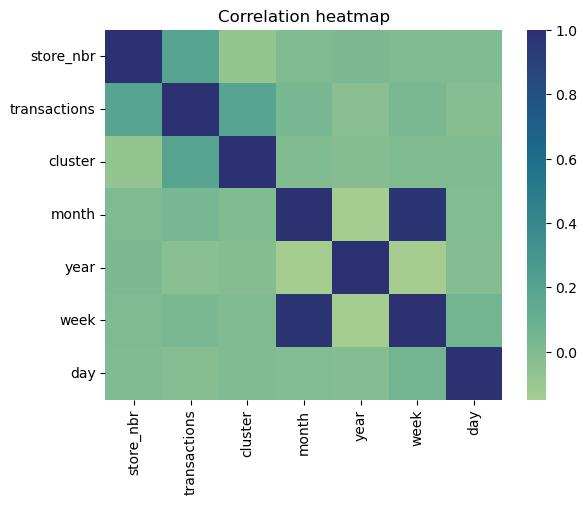

In [544]:
sns.heatmap(data=corr, cmap='crest')
plt.title('Correlation heatmap')

Text(0.5, 1.0, 'Distribution of transactions')

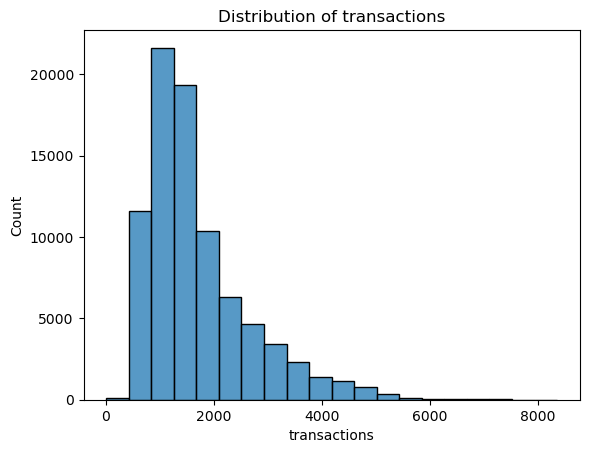

In [545]:
sns.histplot(stores['transactions'], bins=20)
plt.title('Distribution of transactions')

Text(0.5, 1.0, 'Transactions by city')

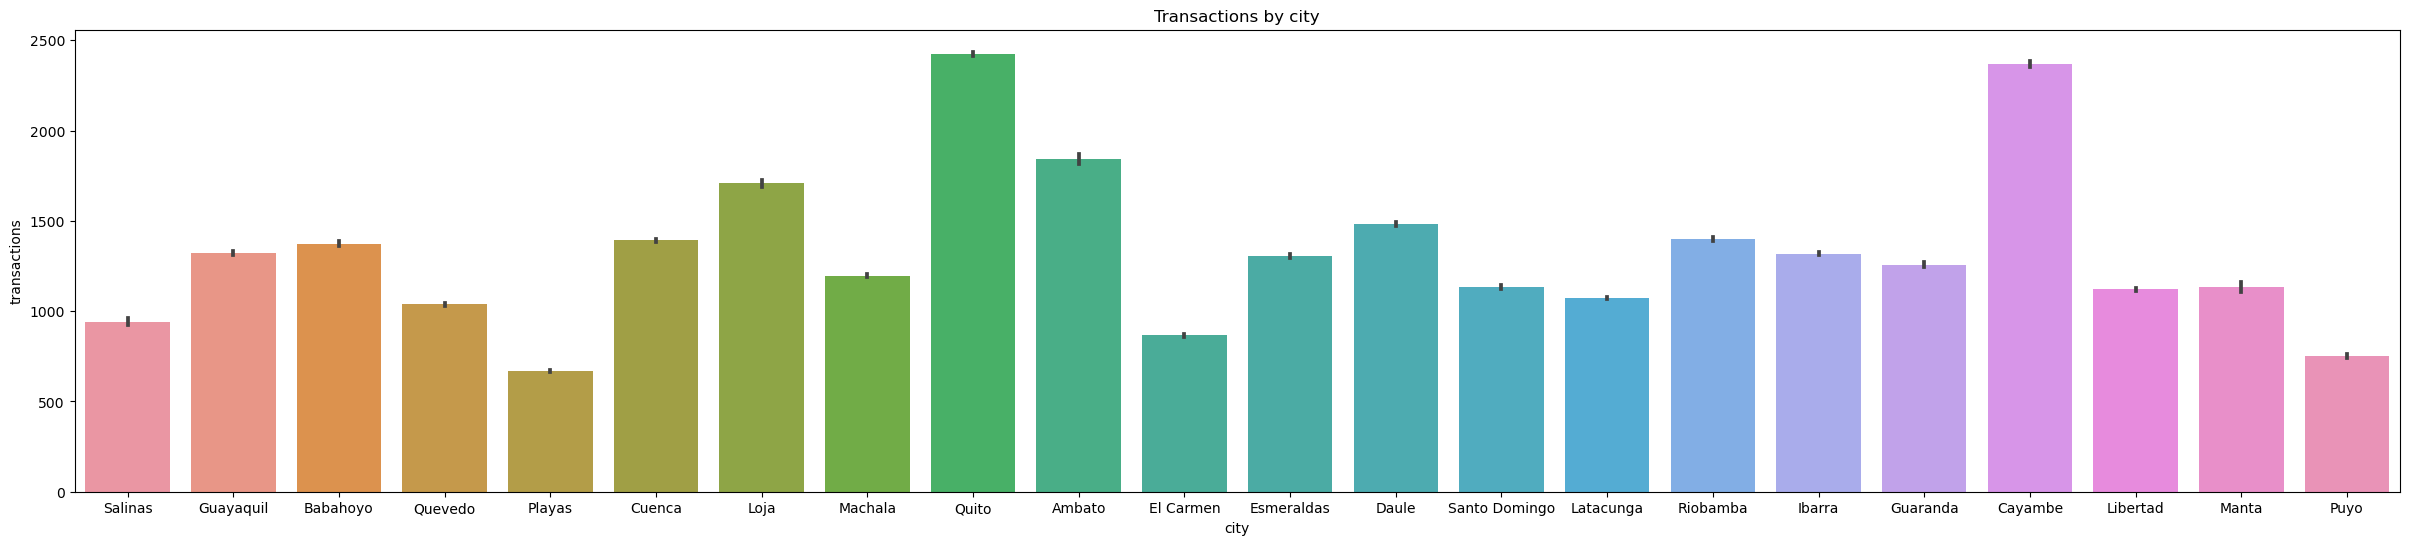

In [546]:
plt.figure(figsize=(30,6))
sns.barplot(data=stores, x='city', y='transactions')
plt.title('Transactions by city')

Text(0.5, 1.0, 'Transaction by state')

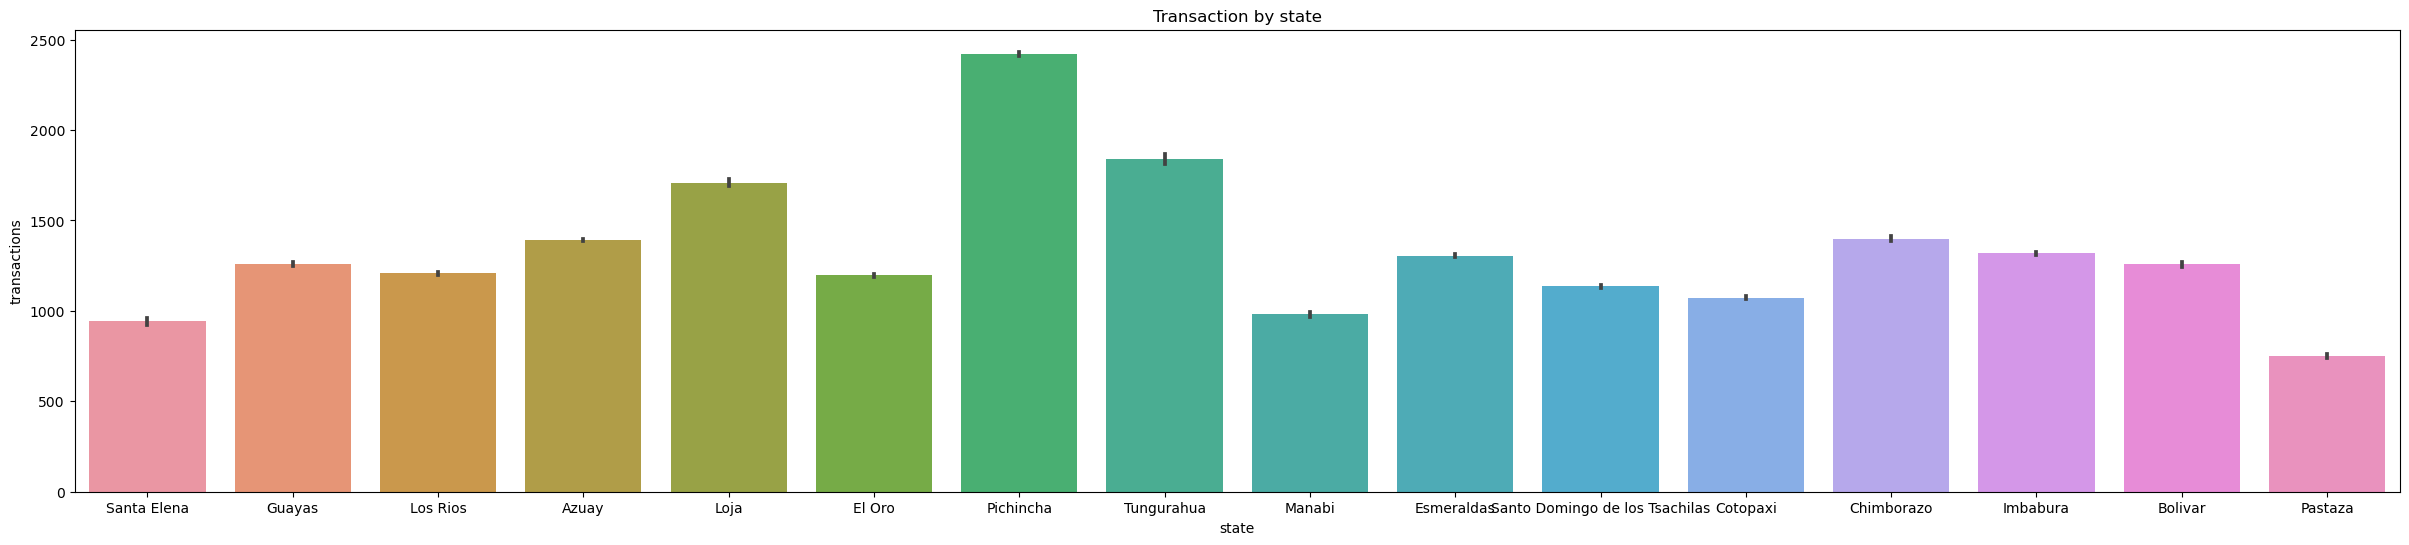

In [547]:
plt.figure(figsize=(30,6))
sns.barplot(data=stores, x='state', y='transactions')
plt.title('Transaction by state')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Transaction by year')

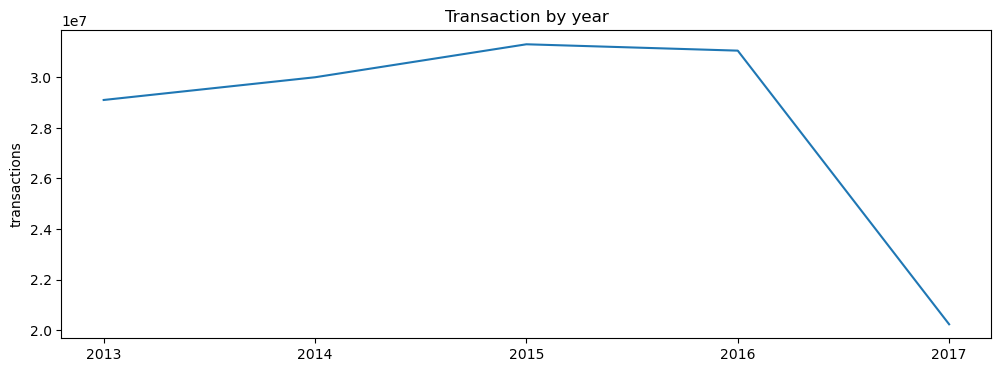

In [548]:
plt.figure(figsize=(12,4))

months = stores.month.unique()

transaction_per_week = stores.groupby('week')['transactions'].sum()
transaction_per_month = stores.groupby('month')['transactions'].sum()
transaction_per_year = stores.groupby('year')['transactions'].sum()

sns.lineplot(x=stores['year'].unique().astype(str), y=transaction_per_year)
plt.title('Transaction by year')

Text(0.5, 1.0, 'Transaction by year')

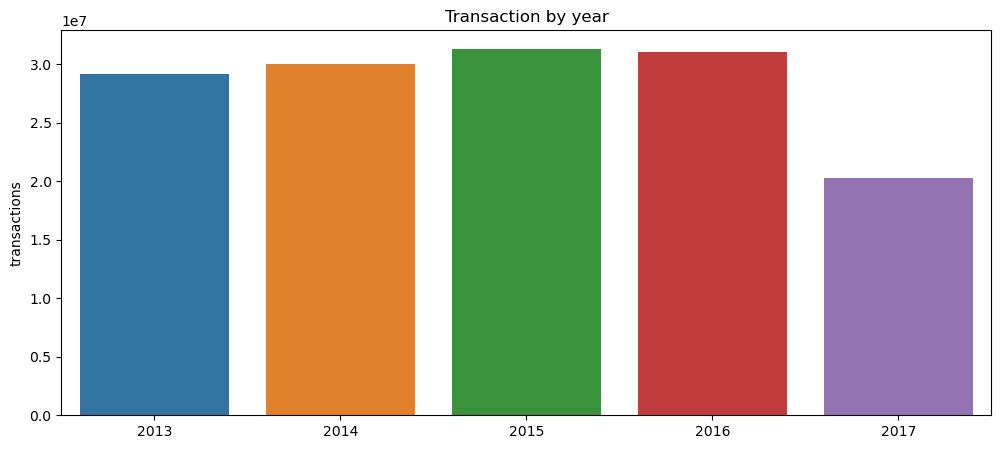

In [549]:
plt.figure(figsize=(12,5))

sns.barplot(x=stores['year'].unique().astype(str), y=transaction_per_year)
plt.title('Transaction by year')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Text(0.5, 1.0, 'Transaction by month')

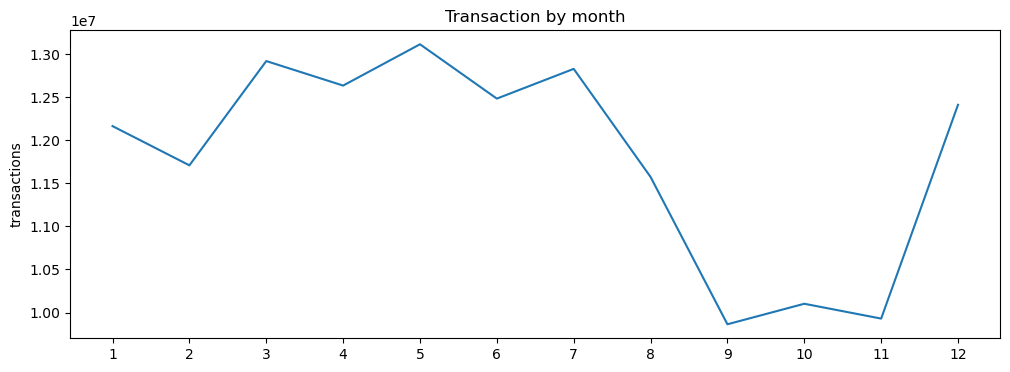

In [550]:
plt.figure(figsize=(12,4))
sns.lineplot(x=stores['month'].unique().astype(str), y=transaction_per_month)
plt.title('Transaction by month')

Text(0.5, 1.0, 'Transaction by month')

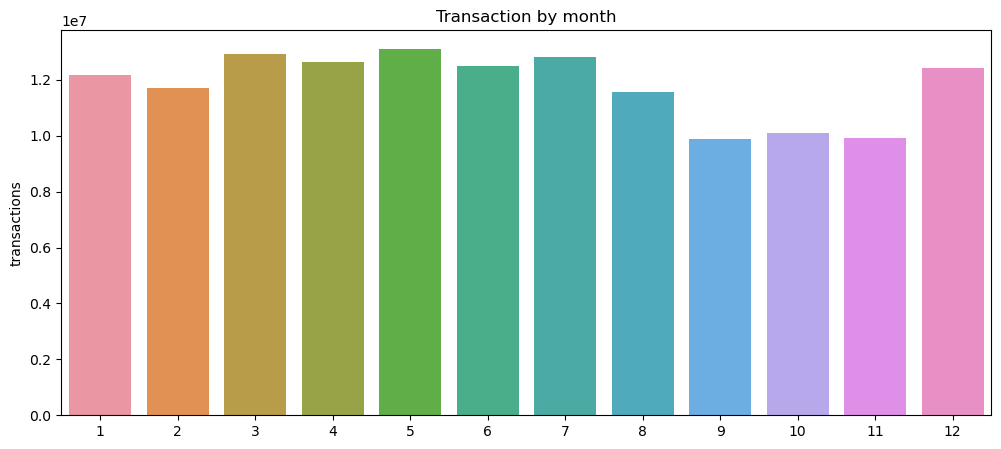

In [551]:
plt.figure(figsize=(12,5))
sns.barplot(x=stores['month'].unique().astype(str), y=transaction_per_month)
plt.title('Transaction by month')

Text(0.5, 1.0, 'Transaction by week')

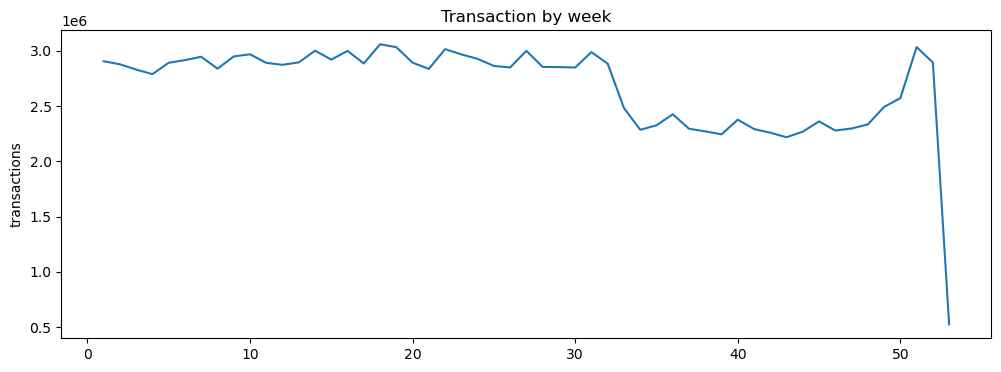

In [552]:
plt.figure(figsize=(12,4))
sns.lineplot(x=stores['week'].unique(), y=transaction_per_week)
plt.title('Transaction by week')

Text(0.5, 1.0, 'Transaction by week')

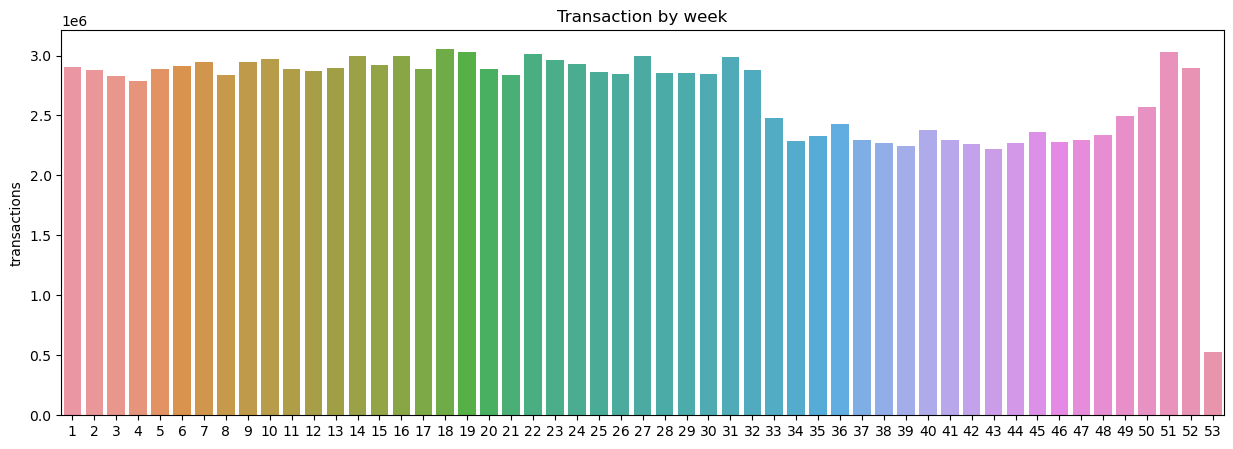

In [553]:
plt.figure(figsize=(15,5))

sns.barplot(x=stores['week'].unique().astype(str), y=transaction_per_week)
plt.title('Transaction by week')

Text(0.5, 1.0, 'Transaction by year')

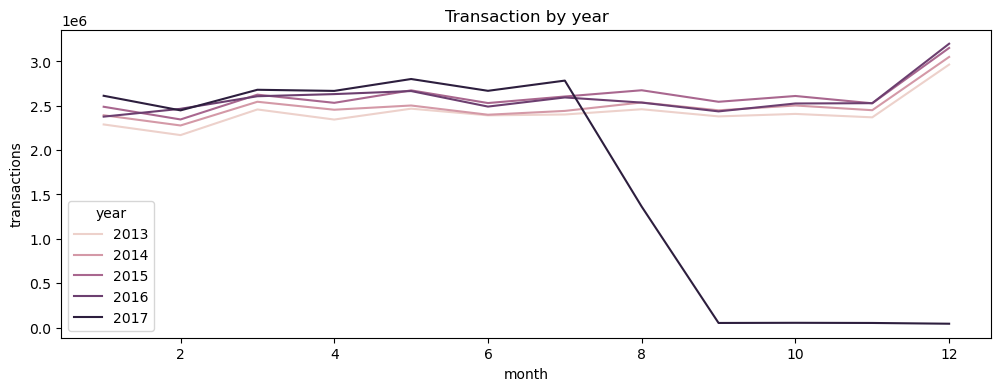

In [554]:
plt.figure(figsize=(12,4))
transactions_per_year = stores.groupby(['year','month'])['transactions'].sum()
transactions_per_year = pd.DataFrame(transactions_per_year)
transactions_per_year = transactions_per_year.reset_index()

sns.lineplot(data=transactions_per_year, x=transactions_per_year['month'], y=transactions_per_year['transactions'],hue=transactions_per_year['year'])
plt.title('Transaction by year')

Text(0.5, 1.0, 'Transactions in 2015')

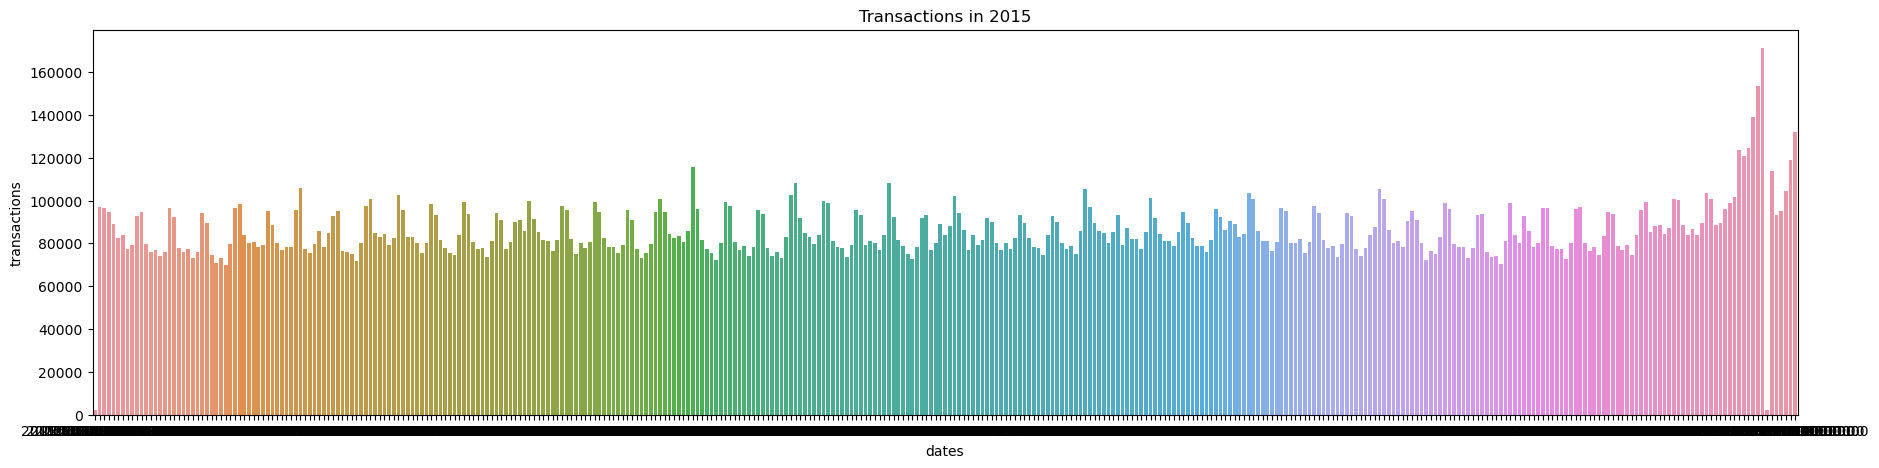

In [555]:
plt.figure(figsize=(22,5))

year = stores[stores['year'] == 2015]

transactions_per_single_year = year.groupby(['dates'])['transactions'].sum()

sns.barplot(x=transactions_per_single_year.index.unique(), y=transactions_per_single_year)
plt.title('Transactions in 2015')

Text(0.5, 1.0, 'Transactions in 2016')

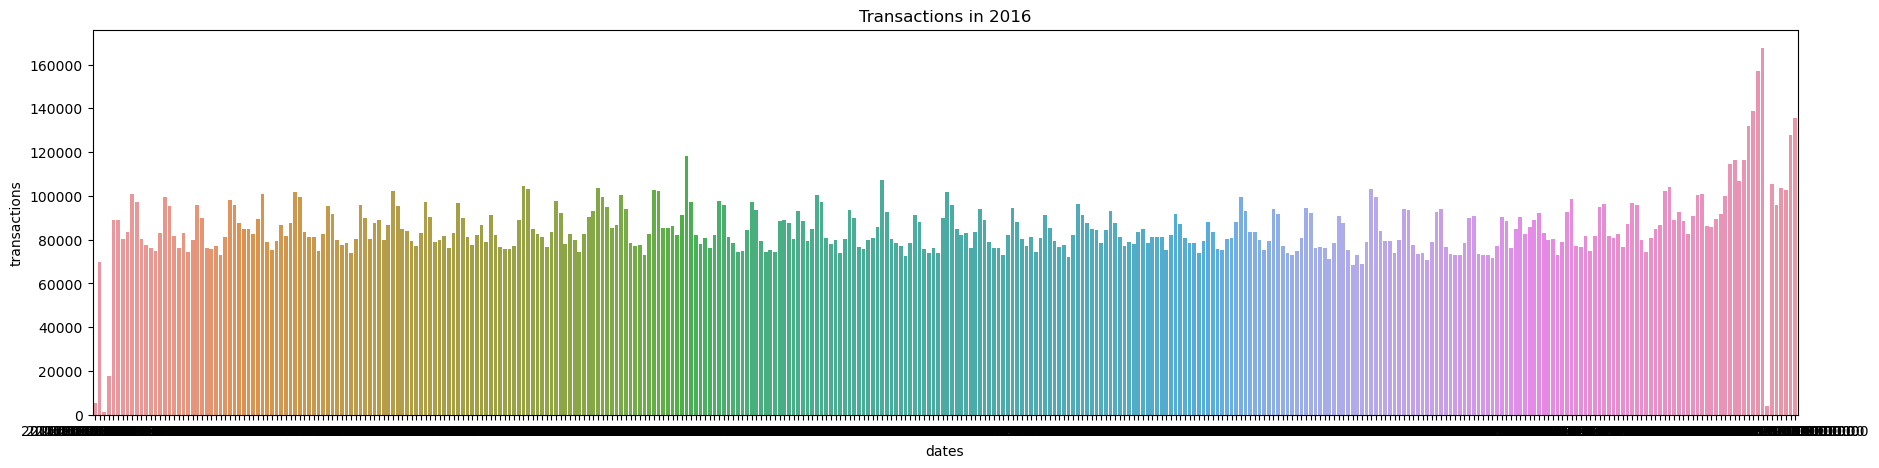

In [556]:
plt.figure(figsize=(22,5))

year = stores[stores['year'] == 2016]

transactions_per_single_year = year.groupby(['dates'])['transactions'].sum()

sns.barplot(x=transactions_per_single_year.index.unique(), y=transactions_per_single_year)
plt.title('Transactions in 2016')

Text(0.5, 1.0, 'Transactions in 2016')

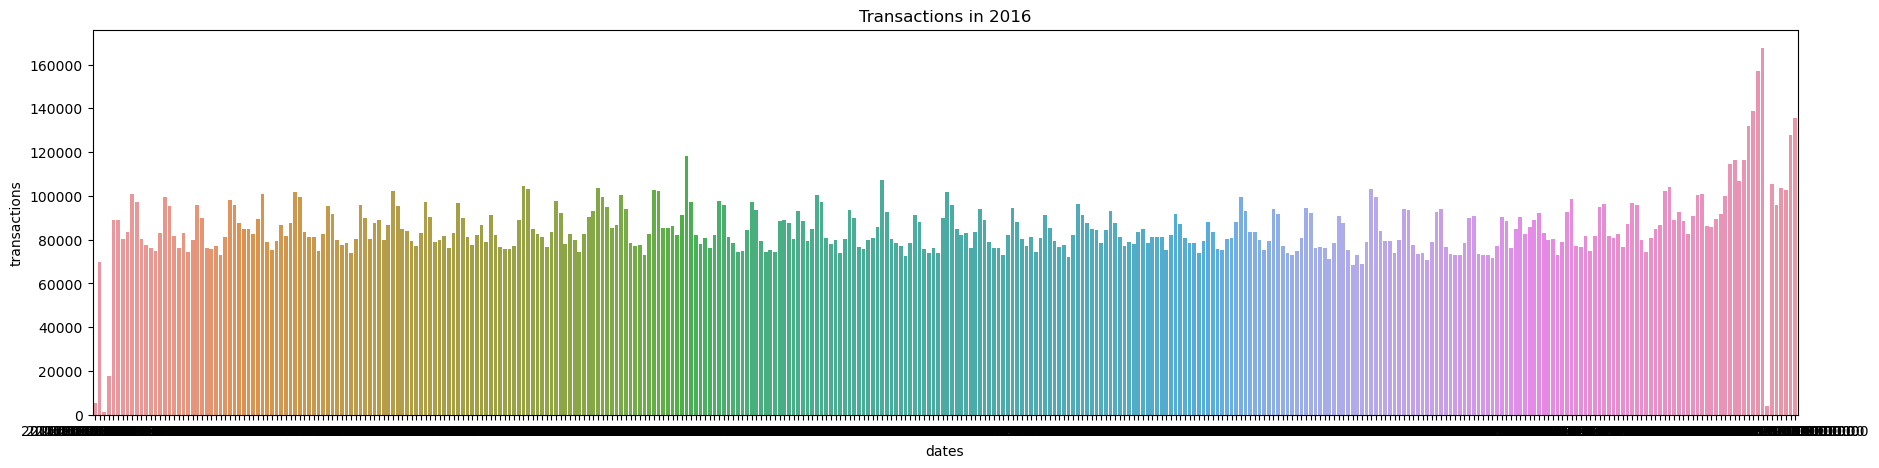

In [557]:
plt.figure(figsize=(22,5))

year = stores[stores['year'] == 2016]

transactions_per_single_year = year.groupby(['dates'])['transactions'].sum()

sns.barplot(x=transactions_per_single_year.index.unique(), y=transactions_per_single_year)
plt.title('Transactions in 2016')

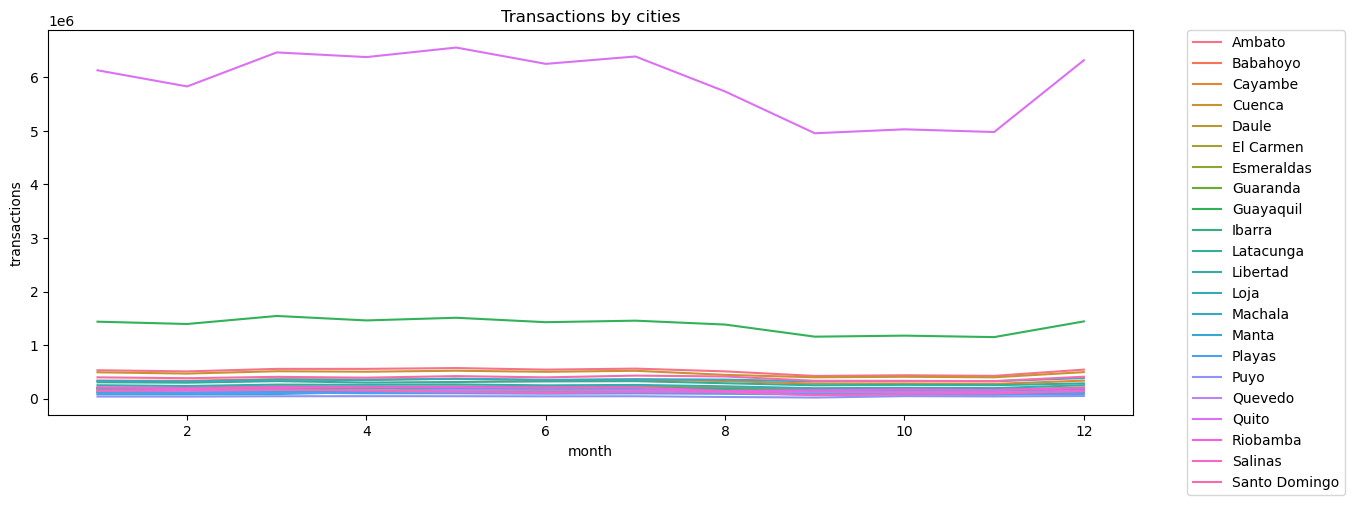

In [558]:
stores['cities'] = stores['city']
city_by_month = stores.groupby(['cities', 'month'])['transactions'].sum()
city_by_month = pd.DataFrame(city_by_month)
city_by_month = city_by_month.reset_index()

plt.figure(figsize=(14,5))
sns.lineplot(data=city_by_month, x=city_by_month['month'], y=city_by_month['transactions'], hue=city_by_month['cities'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Transactions by cities')
stores = stores.drop('cities', axis=1)

Text(0.5, 1.0, 'Count of transactions by cities')

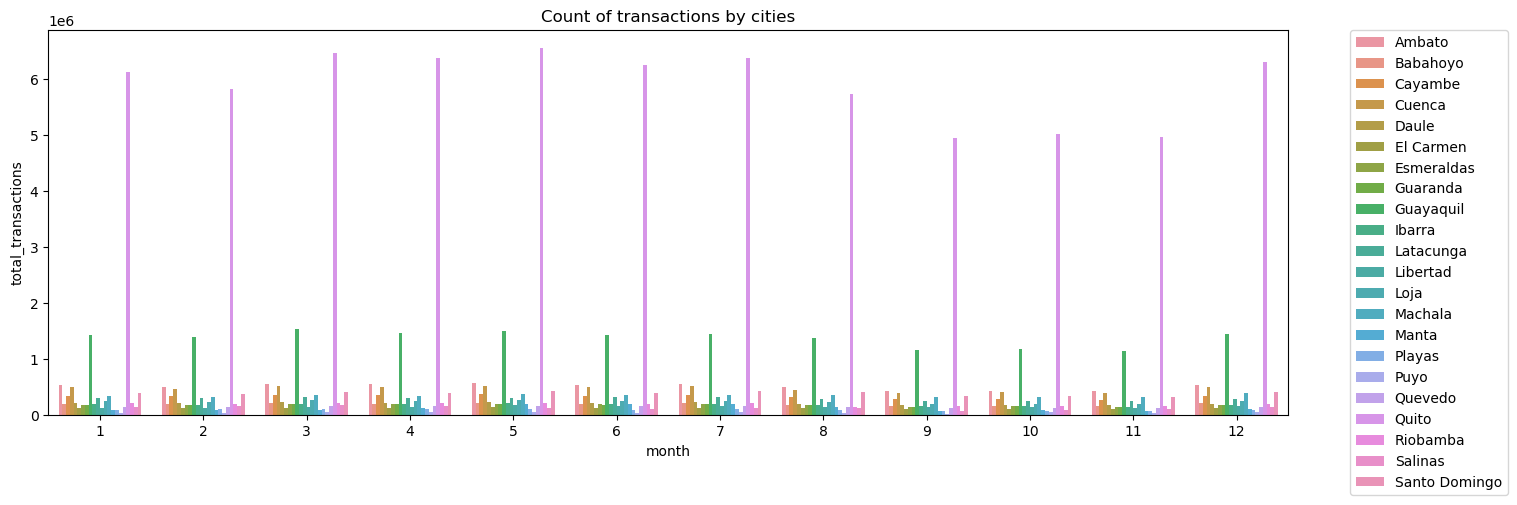

In [559]:
stores['cities'] = stores['city']
city_by_month_count = stores.groupby(['cities', 'month'])['transactions'].count()
city_by_month_count = pd.DataFrame(city_by_month_count)
city_by_month_count = city_by_month_count.reset_index()
city_by_month_count['total_transactions'] = city_by_month['transactions']

plt.figure(figsize=(16,5))
sns.barplot(data=city_by_month_count, x=city_by_month_count['month'], y=city_by_month_count['total_transactions'], hue=city_by_month_count['cities'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Count of transactions by cities')

Text(0.5, 1.0, 'Transactions by type')

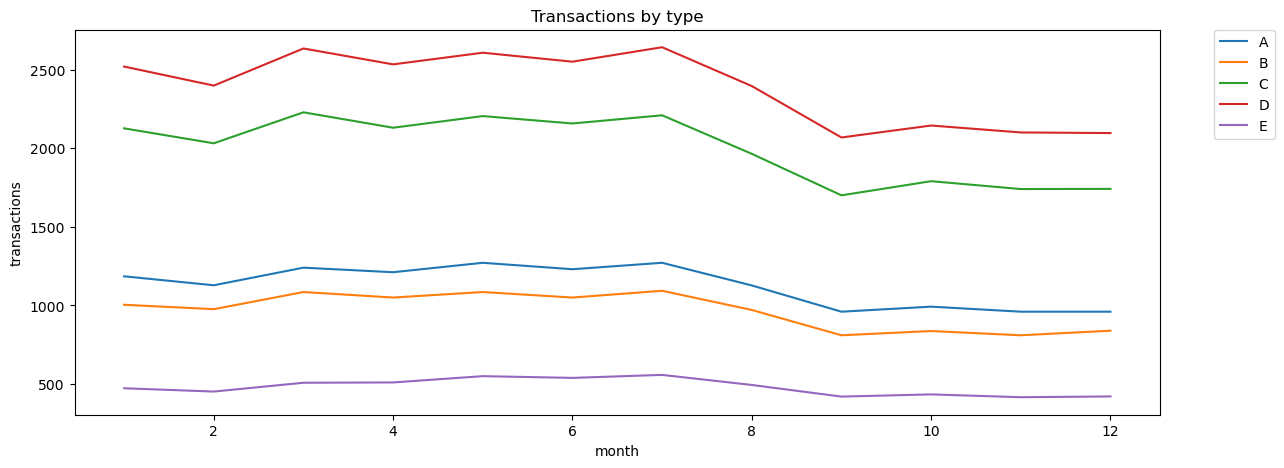

In [560]:
type_by_month = stores.groupby(['type', 'month'])['transactions'].count()
type_by_month = pd.DataFrame(type_by_month)
type_by_month = type_by_month.reset_index()

plt.figure(figsize=(14,5))
sns.lineplot(data=type_by_month, x=type_by_month['month'], y=type_by_month['transactions'], hue=type_by_month['type'])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.title('Transactions by type')

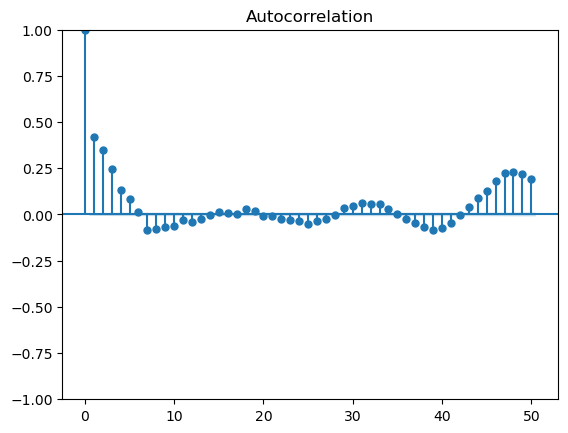

In [561]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

to_plot = pd.DataFrame(stores['transactions'])
to_plot = to_plot.dropna()
acf = plot_acf(to_plot, lags=50)

# Cleaning

In [562]:
target = stores['transactions']
stores = stores.drop('transactions', axis = 1)
stores = stores.drop('store_nbr', axis=1)

stores = pd.concat([target, stores], axis = 1)
stores

,transactions,city,state,type,cluster,month,year,week,day,cities
dates,,,,,,,,,,
2013-01-01,770.000000,Salinas,Santa Elena,D,1.0,1,2013,1,1,Salinas
2013-01-02,708.000000,Guayaquil,Guayas,C,3.0,1,2013,1,2,Guayaquil
2013-01-02,1401.000000,Babahoyo,Los Rios,B,10.0,1,2013,1,2,Babahoyo
2013-01-02,776.000000,Guayaquil,Guayas,C,3.0,1,2013,1,2,Guayaquil
2013-01-02,1163.000000,Quevedo,Los Rios,C,3.0,1,2013,1,2,Quevedo
...,...,...,...,...,...,...,...,...,...,...
2017-12-21,1719.878964,Machala,El Oro,D,4.0,12,2017,51,21,Machala
2017-12-22,1719.878964,Machala,El Oro,D,4.0,12,2017,51,22,Machala
2017-12-23,1719.878964,Machala,El Oro,D,4.0,12,2017,51,23,Machala


In [563]:
target_map = stores['transactions'].to_dict()
stores['lag1'] = (stores.index - pd.Timedelta('364 days')).map(target_map)
stores['lag2'] = (stores.index - pd.Timedelta('728 days')).map(target_map)
stores['lag3'] = (stores.index - pd.Timedelta('1092 days')).map(target_map)

In [564]:
city = pd.get_dummies(stores['city'])
types = pd.get_dummies(stores['type'])
cluster = pd.get_dummies(stores['cluster'])
states = pd.get_dummies(stores['state'])

stores = pd.concat([stores, city], axis=1)
stores = pd.concat([stores, types], axis=1)
stores = pd.concat([stores, cluster], axis=1)
stores = pd.concat([stores, states], axis=1)

stores = stores.drop(['city', 'state', 'type', 'cluster', 'cities', 'week'], axis=1)
stores

,transactions,month,year,day,lag1,lag2,lag3,Ambato,Babahoyo,Cayambe,...,Guayas,Imbabura,Loja,Los Rios,Manabi,Pastaza,Pichincha,Santa Elena,Santo Domingo de los Tsachilas,Tungurahua
dates,,,,,,,,,,,,,,,,,,,,,
2013-01-01,770.000000,1,2013,1,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-02,708.000000,1,2013,2,NaN,NaN,NaN,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2013-01-02,1401.000000,1,2013,2,NaN,NaN,NaN,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2013-01-02,776.000000,1,2013,2,NaN,NaN,NaN,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2013-01-02,1163.000000,1,2013,2,NaN,NaN,NaN,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-21,1719.878964,12,2017,21,1828.0,3943.0,1728.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-22,1719.878964,12,2017,22,1805.0,2393.0,1120.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-12-23,1719.878964,12,2017,23,2367.0,1379.0,939.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [565]:
from sklearn.model_selection import train_test_split

y = stores['transactions']

train = stores.loc[stores.index < '2016-12-30']
test = stores.loc[stores.index >= '2016-12-30']
train

,transactions,month,year,day,lag1,lag2,lag3,Ambato,Babahoyo,Cayambe,...,Guayas,Imbabura,Loja,Los Rios,Manabi,Pastaza,Pichincha,Santa Elena,Santo Domingo de los Tsachilas,Tungurahua
dates,,,,,,,,,,,,,,,,,,,,,
2013-01-01,770.0,1,2013,1,NaN,NaN,NaN,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2013-01-02,708.0,1,2013,2,NaN,NaN,NaN,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2013-01-02,1401.0,1,2013,2,NaN,NaN,NaN,0,1,0,...,0,0,0,1,0,0,0,0,0,0
2013-01-02,776.0,1,2013,2,NaN,NaN,NaN,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2013-01-02,1163.0,1,2013,2,NaN,NaN,NaN,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-29,732.0,12,2016,29,5414.0,2202.0,1320.0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2016-12-29,1389.0,12,2016,29,5414.0,2202.0,1320.0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-12-29,1587.0,12,2016,29,5414.0,2202.0,1320.0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [566]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

train.columns = train.columns.astype(str)
test.columns = test.columns.astype(str)


x = train
x_test = test
y_test = test['transactions']
y_test = np.array(y_test)
x = scaler.fit_transform(x)
x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test.reshape(-1,1))
train_set = pd.DataFrame(x)
test_set = pd.DataFrame(x_test)
y_test = pd.DataFrame(y_test, columns=['True'])

train_set.to_csv("train.csv", header=False, index=False)
test_set.to_csv("validation.csv", header=False, index=False)

train_set.head(50)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sklearn/preprocessing/_data.py:484: RuntimeWarning: divide by zero encountered in true_divide
  self.scale_ = (feature_range[1] - feature_range[0]) / _handle_zeros_in_scale(


,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
0,0.091573,0.0,0.0,0.000000,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.084151,0.0,0.0,0.033333,NaN,NaN,NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.167106,0.0,0.0,0.033333,NaN,NaN,NaN,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.092291,0.0,0.0,0.033333,NaN,NaN,NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.138616,0.0,0.0,0.033333,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.325473,0.0,0.0,0.033333,NaN,NaN,NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.093488,0.0,0.0,0.033333,NaN,NaN,NaN,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.201819,0.0,0.0,0.033333,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.237252,0.0,0.0,0.033333,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.140412,0.0,0.0,0.033333,NaN,NaN,NaN,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [567]:
bucket = sagemaker.Session().default_bucket()
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
bucket

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


'sagemaker-eu-west-2-866647877267'

In [568]:
from sagemaker import image_uris
from sagemaker.inputs import TrainingInput

container = sagemaker.image_uris.retrieve("xgboost", sess.boto_region_name, 'latest')

s3_input_train = TrainingInput(
    s3_data="s3://{}/{}/train".format(bucket, prefix), content_type="csv"
)
s3_input_validation = TrainingInput(
    s3_data="s3://{}/{}/validation/".format(bucket, prefix), content_type="csv"
)

INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.


In [424]:
xgb = sagemaker.estimator.Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path="s3://{}/{}/output".format(bucket, prefix),
    sagemaker_session=sess,
)
xgb.set_hyperparameters(
    max_depth=4,
    eta=0.675,
    verbosity=0,
    objective="reg:linear",
    num_round=100,
    eval_metric='mae'
)

xgb.fit({"train": s3_input_train, "validation" : s3_input_validation})

INFO:sagemaker:Creating training-job with name: xgboost-2023-04-04-05-44-25-222


2023-04-04 05:44:25 Starting - Starting the training job...
2023-04-04 05:44:55 Starting - Preparing the instances for training......
2023-04-04 05:45:44 Downloading - Downloading input data...
2023-04-04 05:46:14 Training - Downloading the training image...
2023-04-04 05:46:49 Training - Training image download completed. Training in progress..Arguments: train
[2023-04-04:05:47:01:INFO] Running standalone xgboost training.
[2023-04-04:05:47:01:INFO] File size need to be processed in the node: 28.25mb. Available memory size in the node: 8611.02mb
[2023-04-04:05:47:01:INFO] Determined delimiter of CSV input is ','
[05:47:01] S3DistributionType set as FullyReplicated
[05:47:01] 71291x70 matrix with 4990370 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2023-04-04:05:47:01:INFO] Determined delimiter of CSV input is ','
[05:47:01] S3DistributionType set as FullyReplicated
[05:47:01] 12335x70 matrix with 863450 entries loaded from /opt/ml/input/data/vali


2023-04-04 05:47:19 Uploading - Uploading generated training model
2023-04-04 05:47:31 Completed - Training job completed
Training seconds: 108
Billable seconds: 108


In [425]:
predictor = xgb.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2023-04-04-05-48-14-829
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-04-04-05-48-14-829
INFO:sagemaker:Creating endpoint with name xgboost-2023-04-04-05-48-14-829


------!

In [520]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

n_jobs = 80
n_parallel_jobs = 10

hpt_ranges = {
    'eta': ContinuousParameter(0.5, 0.8),
    'num_round' : IntegerParameter(100, 700),
    'max_depth' : IntegerParameter(3, 13),
}

tuner_parameters = {
    'estimator': xgb, # The same estimator object we defined above
    'base_tuning_job_name': 'bayesian',
    'objective_metric_name': 'validation:mae',
    'objective_type': 'Minimize',
    'hyperparameter_ranges': hpt_ranges,
    'strategy': 'Bayesian',
    'max_jobs': n_jobs,
    'max_parallel_jobs': n_parallel_jobs,
}

In [521]:
tuner = HyperparameterTuner(**tuner_parameters, early_stopping_type='Auto')
tuner.fit({'train': s3_input_train, 'validation': s3_input_validation}, wait=False)
tuner_name = tuner.describe()['HyperParameterTuningJobName']
print(f'tuning job submitted: {tuner_name}.')

INFO:sagemaker:Creating hyperparameter tuning job with name: bayesian-230404-0619


tuning job submitted: bayesian-230404-0619.


In [529]:
tuner.describe()['BestTrainingJob']

{'TrainingJobName': 'bayesian-230404-0619-014-dfd3c62e',
 'TrainingJobArn': 'arn:aws:sagemaker:eu-west-2:866647877267:training-job/bayesian-230404-0619-014-dfd3c62e',
 'CreationTime': datetime.datetime(2023, 4, 4, 6, 23, 22, tzinfo=tzlocal()),
 'TrainingStartTime': datetime.datetime(2023, 4, 4, 6, 24, 55, tzinfo=tzlocal()),
 'TrainingEndTime': datetime.datetime(2023, 4, 4, 6, 26, 42, tzinfo=tzlocal()),
 'TrainingJobStatus': 'Stopped',
 'TunedHyperParameters': {'eta': '0.5416531248490326',
  'max_depth': '4',
  'num_round': '643'},
 'FinalHyperParameterTuningJobObjectiveMetric': {'MetricName': 'validation:mae',
  'Value': 0.05954200029373169},
 'ObjectiveStatus': 'Succeeded'}

In [530]:
model_data = 's3://sagemaker-eu-west-2-866647877267/Datasets/output/bayesian-230404-0619-053-56b95fb7/output/model.tar.gz'

In [531]:
sm_model = sagemaker.Model(model_data=model_data, image_uri=container, role=role, sagemaker_session=sess)
sm_model.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: xgboost-2023-04-04-06-53-04-458
INFO:sagemaker:Creating endpoint-config with name xgboost-2023-04-04-06-53-05-046
INFO:sagemaker:Creating endpoint with name xgboost-2023-04-04-06-53-05-046


------!

In [532]:
sm_model.endpoint_name

'xgboost-2023-04-04-06-53-05-046'

In [533]:
endpoint_name = 'xgboost-2023-04-04-06-53-05-046'

In [534]:
predictor = sagemaker.Predictor(endpoint_name=endpoint_name)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [569]:
predictor.serializer = sagemaker.serializers.CSVSerializer()

In [570]:
def predict(data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ""
    for array in split_array:
        predictions = ",".join([predictions, predictor.predict(array).decode("utf-8")])
    return np.fromstring(predictions[1:], sep=',')


predictions = predict(test_set.to_numpy()[:,1:])
predictions = [float(i) for i in predictions]
y_test['predicted'] = predictions
y_test

,True,predicted
0,0.265990,0.254360
1,0.904777,0.503263
2,0.993969,0.636239
3,0.257419,0.237462
4,0.268846,0.297859
...,...,...
12330,0.257559,0.189460
12331,0.257559,0.213981
12332,0.257559,0.248172
12333,0.257559,0.234446


In [571]:
predicted = np.array(y_test['predicted']).reshape(-1,1)
true = np.array(y_test['True']).reshape(-1,1)
predicted = scaler.inverse_transform(predicted)
true = scaler.inverse_transform(true)
result = pd.DataFrame(y_test)
result['predicted'] = predicted
result['True'] = true

result

,True,predicted
0,1773.000000,1699.724177
1,5798.000000,3268.062020
2,6360.000000,4105.941514
3,1719.000000,1593.248150
4,1791.000000,1973.811895
...,...,...
12330,1719.878964,1290.790148
12331,1719.878964,1445.294861
12332,1719.878964,1660.732993
12333,1719.878964,1574.242675


In [572]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error

mape = mean_absolute_percentage_error(result['True'], result['predicted'])
mae = mean_absolute_error(result['True'], result['predicted'])

print("The mean absolute percentage error is {}".format(round(mape, 3)))
print("The mean absolute error is {}".format(round(mae, 3)))

The mean absolute percentage error is 0.202
The mean absolute error is 377.704


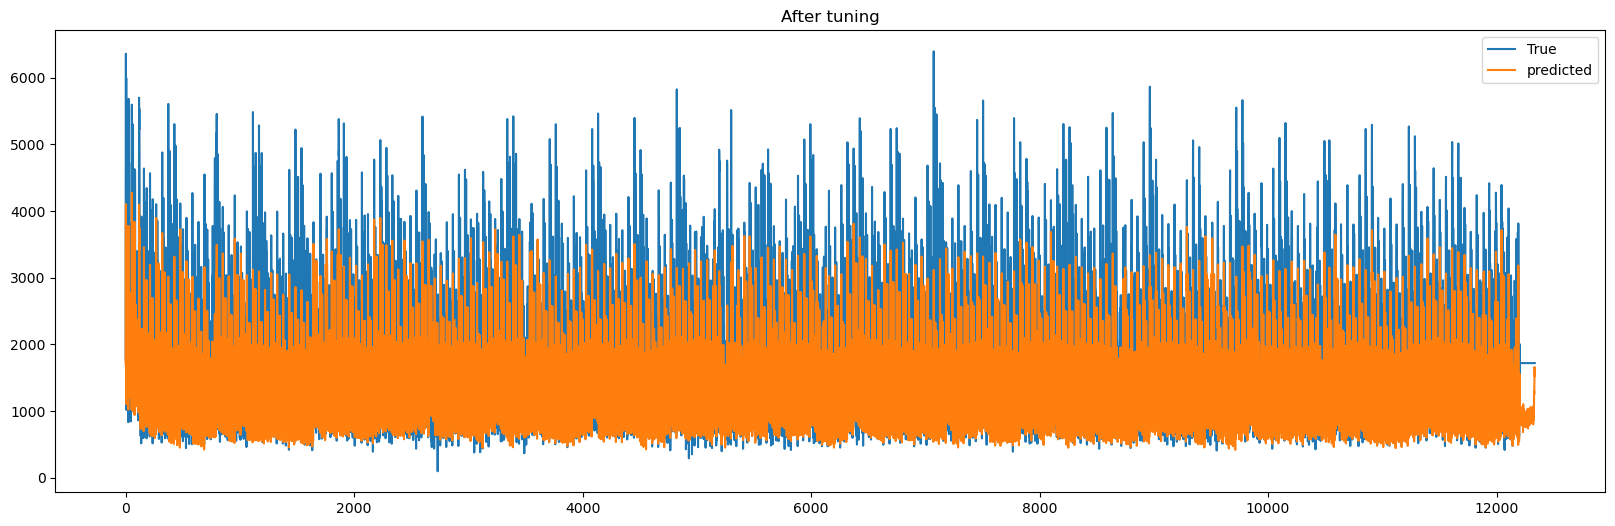

In [573]:
plt.figure(figsize=(20,6))
plt.plot(result['True'], label='True')
plt.plot(result['predicted'], label='predicted')
plt.legend()
plt.title('After tuning')
plt.show()